In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [4]:
def count_el(lista):
    stos = [lista]
    licznik = 0
    while stos:
        aktualna_lista = stos.pop()
        for element in aktualna_lista:
            if isinstance(element, (list, tuple)):
                stos.append(element)
            else:
                licznik += 1
    return licznik

In [5]:
# Filtrowanie data_tr
filtered_data_tr = []
for onto, X, y in zip(data_tr[0], data_tr[1], data_tr[2]):
    if count_el(X) <= 3:
        filtered_data_tr.append([onto, X, y])

# Przekształcenie z powrotem do oryginalnego formatu
new_data_tr = [[], [], []]
for item in filtered_data_tr:
    new_data_tr[0].append(item[0])
    new_data_tr[1].append(item[1])
    new_data_tr[2].append(item[2])

# Przypisanie przefiltrowanych danych z powrotem do data_tr
data_tr = new_data_tr

print(f"Liczba elementów po filtrowaniu: {len(data_tr[0])}")

Liczba elementów po filtrowaniu: 39894


In [6]:
# Filtrowanie data_tr
filtered_data_vl = []
for onto, X, y in zip(data_vl[0], data_vl[1], data_vl[2]):
    if count_el(X) >= 4:
        filtered_data_vl.append([onto, X, y])

# Przekształcenie z powrotem do oryginalnego formatu
new_data_vl = [[], [], []]
for item in filtered_data_vl:
    new_data_vl[0].append(item[0])
    new_data_vl[1].append(item[1])
    new_data_vl[2].append(item[2])

# Przypisanie przefiltrowanych danych z powrotem do data_tr
data_vl = new_data_vl

print(f"Liczba elementów po filtrowaniu: {len(data_vl[0])}")

Liczba elementów po filtrowaniu: 6053


In [7]:
emb_size = 10
hidden_size = 16
epoch_count = 10
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
train_logger = train(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size)

created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each
train epoch 00/10 | batch 1248/1247 | loss 0.7197 | val loss 0.7213 | acc 0.2052 | f1 0.3405 | prec 0.2053 | recall 0.9976 | roc auc 0.5395 | pr auc 0.2460 | elapsed 11.66s
train epoch 01/10 | batch 1248/1247 | loss 0.6165 | val loss 0.5391 | acc 0.8031 | f1 0.0831 | prec 0.9818 | recall 0.0434 | roc auc 0.5296 | pr auc 0.3048 | elapsed 24.34s
train epoch 02/10 | batch 1248/1247 | loss 0.5101 | val loss 0.4839 | acc 0.8062 | f1 0.1814 | prec 0.6915 | recall 0.1044 | roc auc 0.6391 | pr auc 0.4013 | elapsed 24.74s
train epoch 03/10 | batch 1248/1247 | loss 0.4114 | val loss 0.4695 | acc 0.8146 | f1 0.3361 | prec 0.6382 | recall 0.2281 | roc auc 0.6931 | pr auc 0.4622 | elapsed 23.04s
train epoch 04/10 | batch 1248/1247 | loss 0.3249 | val loss 0.4732 | acc 0.8241 | f1 0.4080 | prec 0.6625 | recall 0.2948 | roc auc 0.7242 | pr auc 0.5143 | elapsed 21.92s
train epoch 05/10 | batch 1248/1247 | loss 0.2599 |

In [8]:
# Filtrowanie data_tr
filtered_data_te = []
for onto, X, y in zip(data_te[0], data_te[1], data_te[2]):
    if count_el(X) >= 4:
        filtered_data_te.append([onto, X, y])

# Przekształcenie z powrotem do oryginalnego formatu
new_data_te = [[], [], []]
for item in filtered_data_te:
    new_data_te[0].append(item[0])
    new_data_te[1].append(item[1])
    new_data_te[2].append(item[2])

# Przypisanie przefiltrowanych danych z powrotem do data_tr
data_te_te = new_data_te

print(f"Liczba elementów po filtrowaniu: {len(data_te_te[0])}")

Liczba elementów po filtrowaniu: 15217


In [9]:
# Filtrowanie data_tr
filtered_data_te = []
for onto, X, y in zip(data_te[0], data_te[1], data_te[2]):
    if count_el(X) < 4:
        filtered_data_te.append([onto, X, y])

# Przekształcenie z powrotem do oryginalnego formatu
new_data_te = [[], [], []]
for item in filtered_data_te:
    new_data_te[0].append(item[0])
    new_data_te[1].append(item[1])
    new_data_te[2].append(item[2])

# Przypisanie przefiltrowanych danych z powrotem do data_tr
data_te_tr = new_data_te

print(f"Liczba elementów po filtrowaniu: {len(data_te_tr[0])}")

Liczba elementów po filtrowaniu: 24783


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_test = pd.DataFrame({
    'ontology_id': data_te_te[0],
    'X': data_te_te[1],
    'y': data_te_te[2]
})

def stratified_group_split(data, group_col, stratify_col, test_size=0.5, val_size=0.5):
    groups = data[group_col].unique()
    val_idx, test_idx = [], []

    for group in groups:
        group_data = data[data[group_col] == group]
        val_data, test_data = train_test_split(group_data, test_size=test_size, stratify=group_data[stratify_col], random_state=seed)

        val_idx.extend(val_data.index)
        test_idx.extend(test_data.index)

    return data.loc[val_idx], data.loc[test_idx]

val_data, test_data = stratified_group_split(data_test, 'ontology_id', 'y', test_size=0.5, val_size=0.5)


X_te_val = val_data['X'].tolist()
y_te_val = val_data['y'].tolist()
idx_te_val = val_data['ontology_id'].tolist()

data_te_vl = [idx_te_val, X_te_val, y_te_val] 

X_te_te =  test_data['X'].tolist()
y_te_te = test_data['y'].tolist()
idx_te_te = test_data['ontology_id'].tolist()


In [11]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 776/775 | loss 0.9559 | val loss 0.8470 | acc 0.7141 | f1 0.3636 | prec 0.3284 | recall 0.4072 | roc auc 0.6500 | pr auc 0.3936 | elapsed 6.19s
train epoch 01/10 | batch 776/775 | loss 0.8373 | val loss 0.7434 | acc 0.7429 | f1 0.3889 | prec 0.3716 | recall 0.4079 | roc auc 0.6790 | pr auc 0.4279 | elapsed 11.20s
train epoch 02/10 | batch 776/775 | loss 0.6146 | val loss 0.6675 | acc 0.7695 | f1 0.4182 | prec 0.4234 | recall 0.4131 | roc auc 0.7040 | pr auc 0.4627 | elapsed 11.17s
train epoch 03/10 | batch 776/775 | loss 0.4554 | val loss 0.6160 | acc 0.7888 | f1 0.4439 | prec 0.4703 | recall 0.4203 | roc auc 0.7245 | pr auc 0.4950 | elapsed 11.47s
train epoch 04/10 | batch 776/775 | loss 0.3490 | val loss 0.5816 | acc 0.8024 | f1 0.4646 | prec 0.5086 | recall 0.4275 | roc auc 0.7404 | pr auc 0.5222 | elapsed 11.14s
train epoch 05/10 | batch 776/775 | loss 0.2802 | val loss 0.5593 | acc 0.8147 | f1 0.4889 | prec 0.5471 | recall 0.4420 | roc au

In [12]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te_te, y_te_te, idx_te_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240712T164343


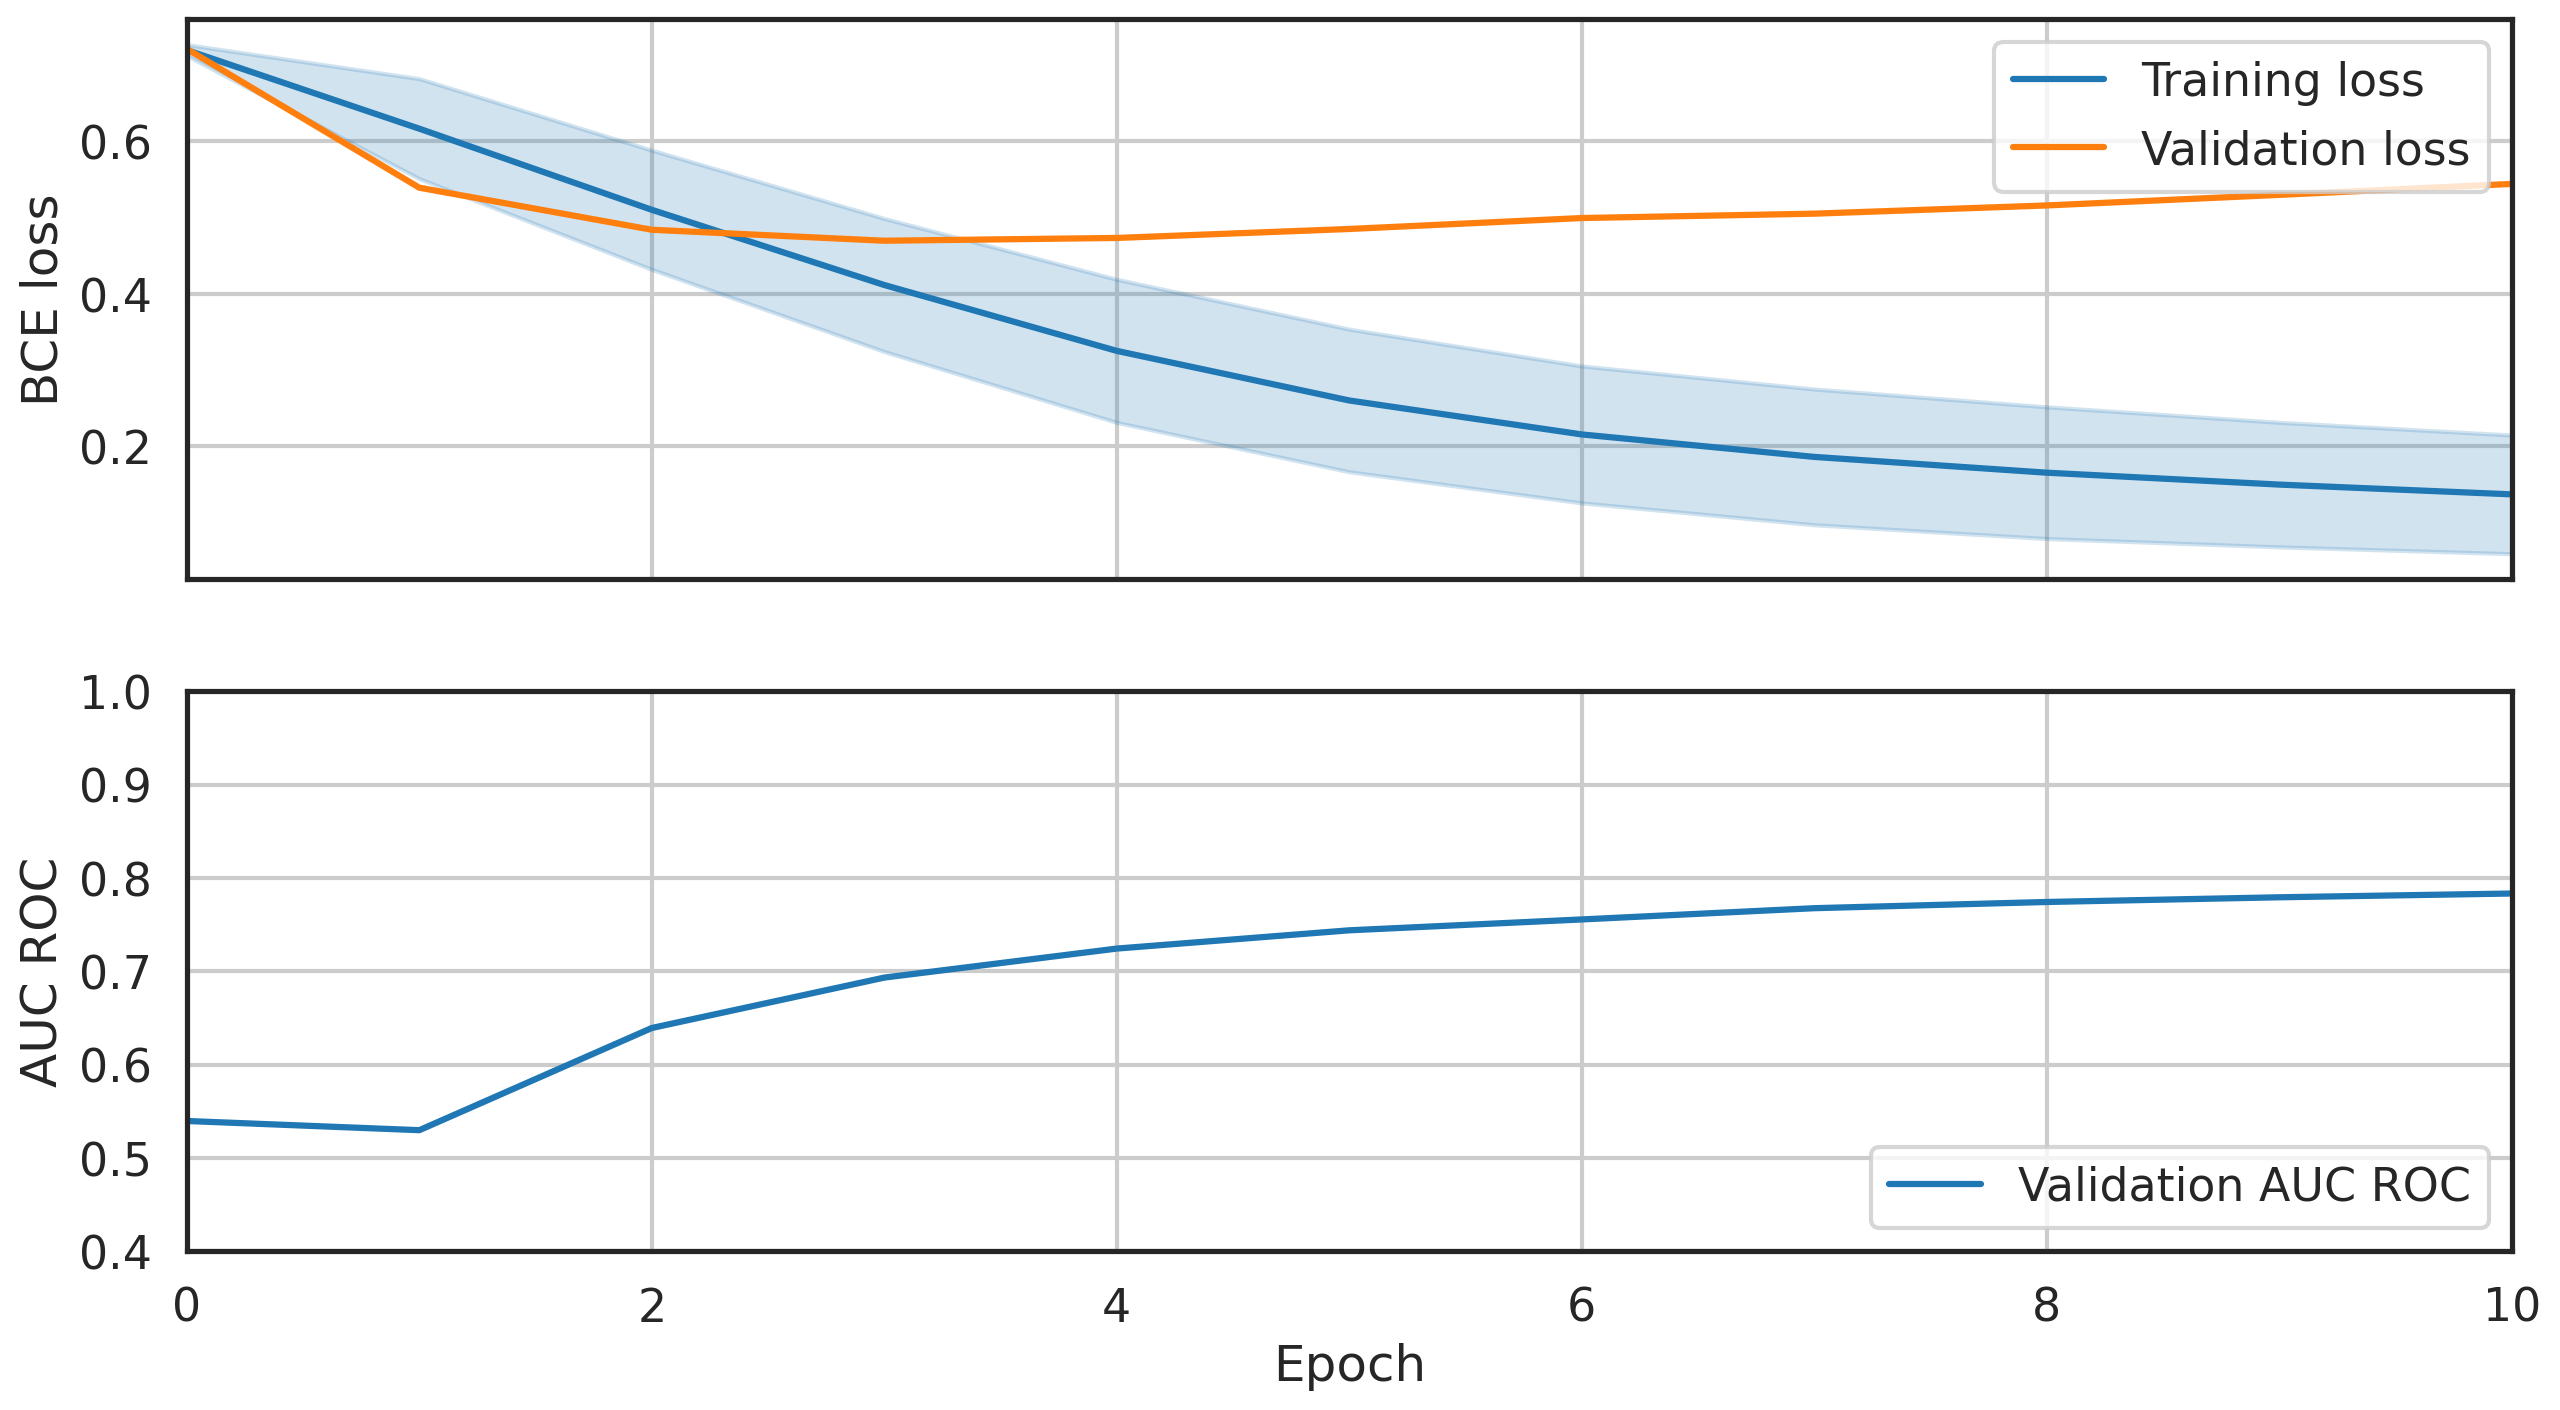

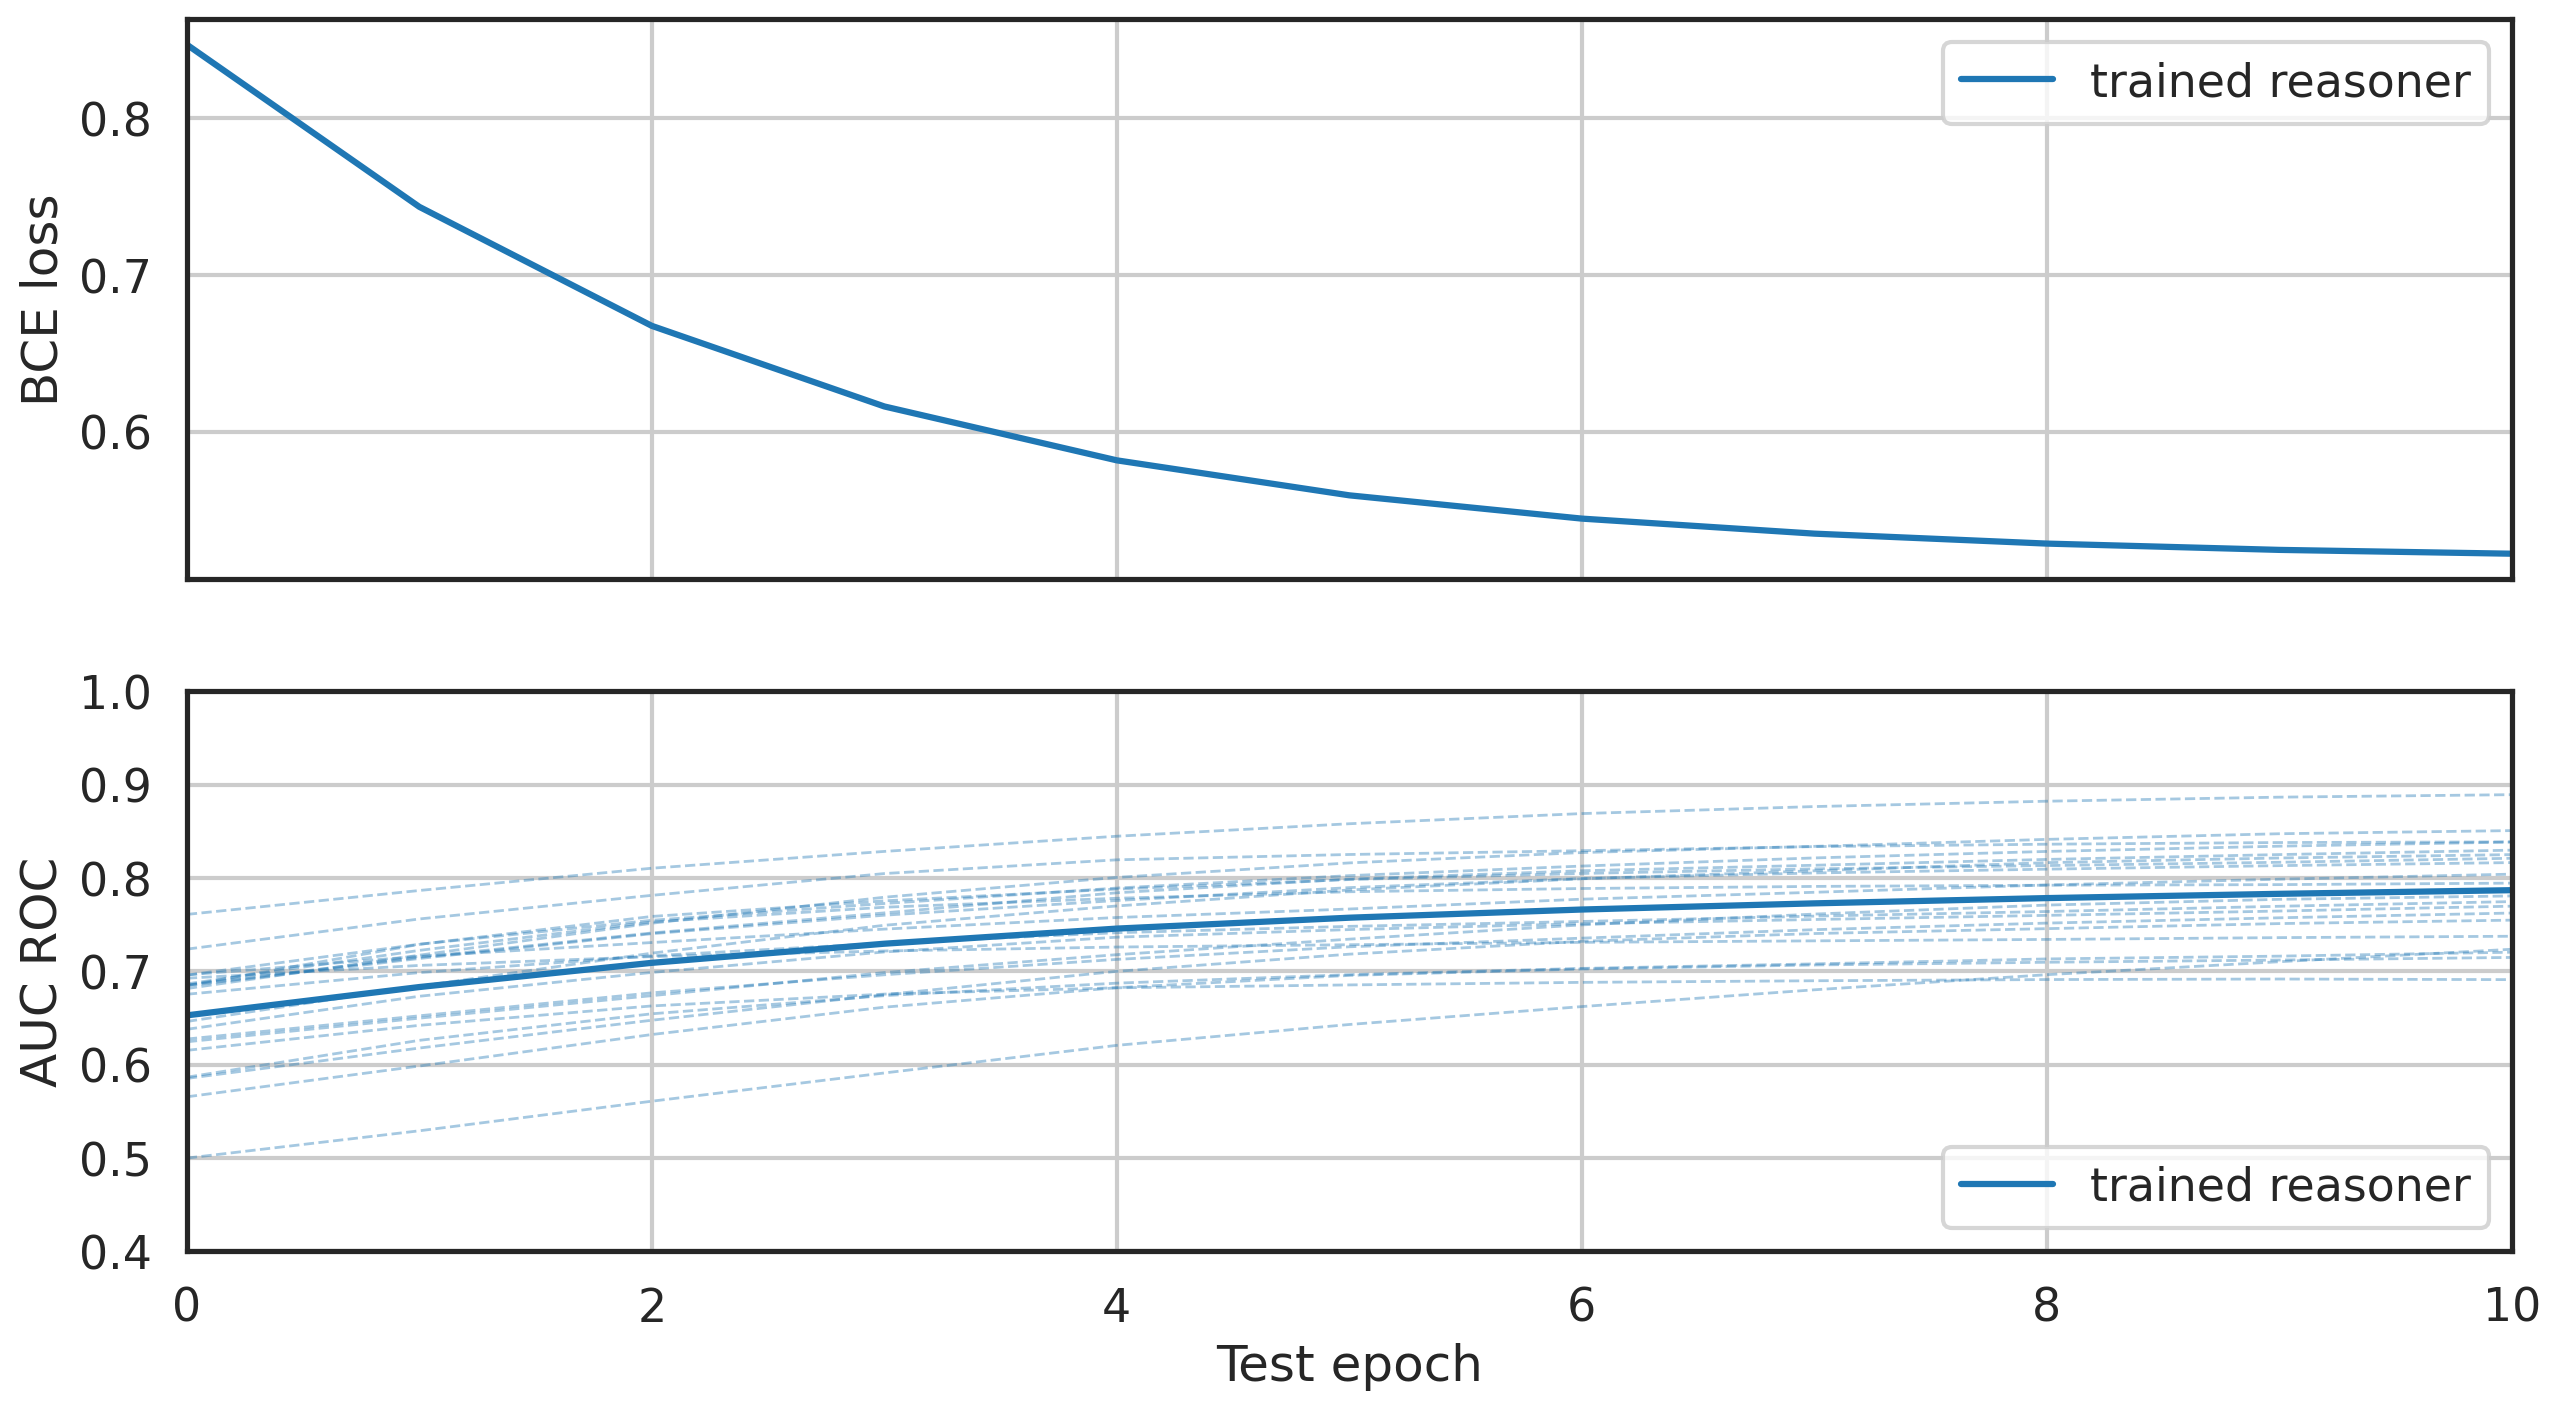

             mean       std     micro
acc      0.832978  0.040857  0.832895
prec     0.632430  0.133930  0.612210
recall   0.467173  0.100318  0.464449
f1       0.525358  0.077420  0.528190
auc_roc  0.775655  0.051446  0.771465
auc_pr   0.619931  0.083655  0.606814


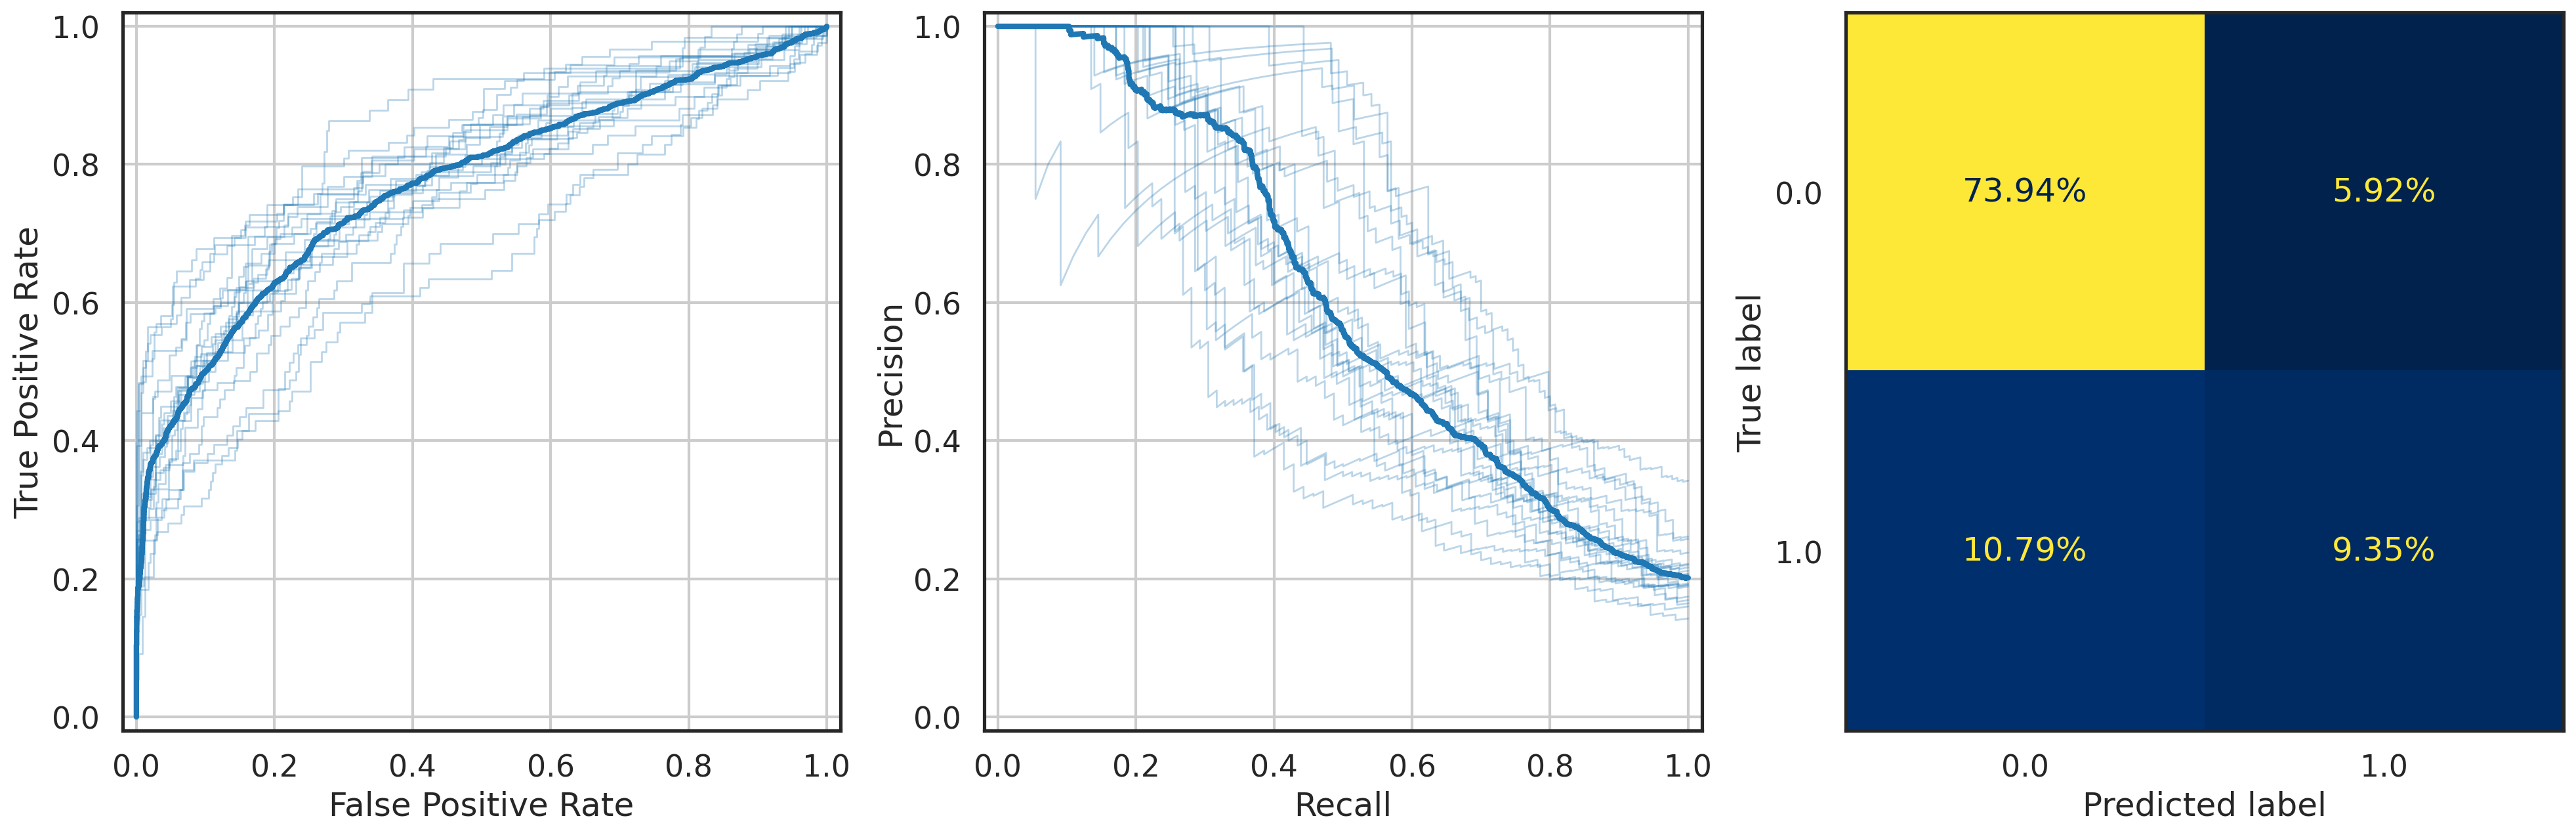

In [13]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te_te, y_te=y_te_te, Y_te_good=Y_te_good))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te_te, np.array(Y_te_good), idx_te_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [14]:
import random

In [15]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im( input, input)))
print(np.mean(losses))

tensor([-0.2352,  0.1052, -0.0100,  0.0841, -0.1440,  0.0378, -0.3109, -0.3351,
         0.2234,  0.1859], grad_fn=<SelectBackward0>)
tensor([-0.0368, -0.2116,  0.1316,  0.1370,  0.1859, -0.0975,  0.1876, -0.1213,
         0.2175,  0.0709], grad_fn=<AddBackward0>)
0.13045579846948385


In [16]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([-0.1605, -0.5000,  0.6744,  0.6617, -0.7724,  0.6656, -0.4715,  0.1904,
        -0.1963, -0.0845], grad_fn=<SelectBackward0>)
tensor([-0.3156, -0.3580,  0.3053, -0.1490,  0.5385, -0.4391,  0.4054, -0.4079,
         0.4929,  0.1871], grad_fn=<AddBackward0>)
0.6712756812572479


In [17]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([ 0.1045, -0.1681, -0.0584,  0.0253, -0.2304, -0.2126,  0.0386, -0.0847,
        -0.0133, -0.0614], grad_fn=<SelectBackward0>)


tensor([ 0.0573,  0.0834, -0.0593,  0.1680,  0.1449,  0.0340, -0.0868, -0.0539,
         0.0276, -0.1016], grad_fn=<AddBackward0>)
0.14440713711082936


In [18]:
losses = []
for _ in range(20):

    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([-0.1605, -0.5000,  0.6744,  0.6617, -0.7724,  0.6656, -0.4715,  0.1904,
        -0.1963, -0.0845], grad_fn=<SelectBackward0>)
tensor([ 0.0922,  0.1099, -0.1136,  0.1053,  0.0257,  0.0958, -0.0002,  0.0774,
        -0.0950, -0.1095], grad_fn=<AddBackward0>)
0.44911348521709443


In [19]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([-0.1605, -0.5000,  0.6744,  0.6617, -0.7724,  0.6656, -0.4715,  0.1904,
        -0.1963, -0.0845], grad_fn=<SelectBackward0>)
tensor([ 0.2110,  0.4512,  0.6887,  0.4629,  0.0959, -0.1998, -0.2411,  0.4795,
         0.4431, -0.4890], grad_fn=<AddBackward0>)
tensor(0.4833, grad_fn=<L1LossBackward0>)


In [20]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([ 0.4134,  0.0615,  0.3127, -0.0368,  0.3009, -0.8497, -0.8911,  0.8050,
        -0.0981, -0.0550], grad_fn=<SelectBackward0>)
tensor([ 0.2608,  0.4456,  0.1664,  0.1679, -0.1975, -0.0258, -0.1465,  0.2231,
        -0.3329, -0.4815], grad_fn=<AddBackward0>)
tensor(0.4198, grad_fn=<L1LossBackward0>)


In [21]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))), trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))))
print(trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.0405,  0.0694, -0.1087,  0.1263,  0.0403,  0.0522,  0.0067,  0.0454,
        -0.0300, -0.0850], grad_fn=<AddBackward0>)
tensor([ 0.0169,  0.0384, -0.1384,  0.0918,  0.0746,  0.0358,  0.0334,  0.0153,
        -0.0412, -0.0505], grad_fn=<AddBackward0>)
0.05345713216811419


In [22]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im(input1, input2)), trained_reasoner.and_nn(im(input2, input1))).item())

print(trained_reasoner.and_nn(im(input1, input2)))
print(trained_reasoner.and_nn(im(input2, input1)))

print(np.mean(losses))

tensor([ 0.0495,  0.0582, -0.0386,  0.2073,  0.0743,  0.0324,  0.0015,  0.0338,
        -0.0408, -0.0750], grad_fn=<AddBackward0>)
tensor([ 0.0449,  0.0163, -0.0620,  0.1982,  0.0783,  0.1063, -0.0344,  0.0496,
         0.0011, -0.0713], grad_fn=<AddBackward0>)
0.040905542531982066


In [23]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([-0.0518, -0.1375,  0.0324,  0.0789, -0.1530,  0.1835, -0.0725, -0.0651,
         0.3122,  0.0717], grad_fn=<SelectBackward0>)
tensor([-0.1216, -0.0115,  0.1295,  0.3613,  0.2722, -0.2502,  0.1394, -0.0681,
         0.1353,  0.0082], grad_fn=<AddBackward0>)
0.1813949577510357


In [24]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9847885191440582


In [25]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.9820231795310974
